# Download dataset
https://www.analyticsvidhya.com/blog/2023/02/fast-food-classification-using-transfer-learning-with-pytorch/

In [5]:
! pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.3/26.3 MB 38.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.2/184.2 kB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 131.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 156.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 23.5 MB/s eta 0:00:00
     ━━

In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! echo '{"username":"zostzost","key":"8d63e017dbd6f9bce2033215ff33031c"}' > ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! rm fast-food-classification-dataset.zip
! rm -r 'downloadable_data/Fast Food Classification V2'
! kaggle datasets download -d utkarshsaxenadn/fast-food-classification-dataset
! unzip -q fast-food-classification-dataset -d downloadable_data
! rm fast-food-classification-dataset.zip


[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
rm: cannot remove 'fast-food-classification-dataset.zip': No such file or directory
rm: cannot remove 'downloadable_data/Fast Food Classification V2': No such file or directory
 99%|███████████████████████████████████████▊| 816M/821M [00:32<00:00, 35.8MB/s]
100%|████████████████████████████████████████| 821M/821M [00:32<00:00, 26.1MB/s]


cpu
['Baked Potato', 'Burger', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Pizza', 'Sandwich', 'Taco', 'Taquito']


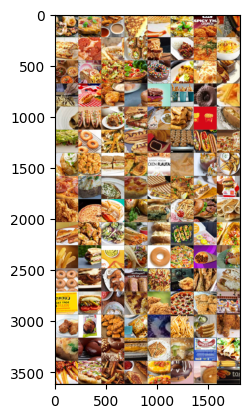

In [24]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import time
import os
import copy

PATH = "downloadable_data/Fast Food Classification V2/"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(os.path.join(PATH, x),
                            data_transforms[x]) for x in ['Train', 'Valid']
}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], 
                                   batch_size=128
                                   ,
                                   shuffle=True, 
                                ) for x in ['Train', 'Valid']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Valid']}

class_names = image_datasets['Train'].classes
print(class_names)

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [25]:
from tqdm import tqdm
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Valid']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'Valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # Save checkoint
        name = f"nn.epoch.{epoch}"
        torch.save({
            "epoch": epoch,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict()
        }, name)
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Valid Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [26]:
model_1 = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model_1.fc = nn.Linear(model_1.fc.in_features, len(class_names))
model_1 = model_1.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_sgd = optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9)
optimizer_adam = optim.Adam(model_1.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_adam, step_size=7, gamma=0.1)

model_1 = train_model(
    model_1,
    criterion,
    optimizer_adam,
    exp_lr_scheduler,
    num_epochs=2)
visualize_model(model_1)

Epoch 0/1
----------


  0%|          | 0/118 [00:00<?, ?it/s]

  1%|          | 1/118 [00:17<34:35, 17.74s/it]

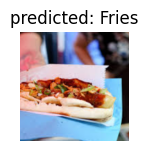

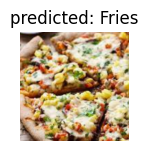

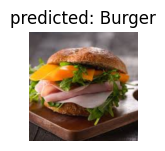

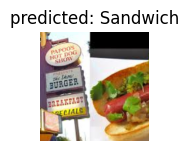

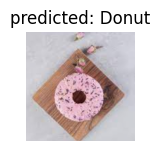

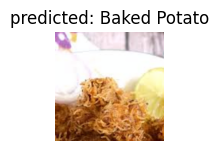

In [17]:
# https://stackoverflow.com/questions/42703500/how-do-i-save-a-trained-model-in-pytorch
# MODEL_PATH = "trained_model"
# torch.save(model_resnetft, MODEL_PATH)
# visualize_model(torch.load(MODEL_PATH))